In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 배치크기 * 채널 (1: 그레이스케일, 3: 컬러) * 너비 * 높이
inputs = torch.Tensor(1,1,28,28)
print(inputs.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# 첫번째 Conv2D
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
out = conv1(inputs)
print(out.shape)

torch.Size([1, 32, 28, 28])


In [ ]:
# 첫번쨰 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 32, 14, 14])


In [ ]:
# 두번째 Conv2D
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
out = conv2(out)
print(out.shape)

torch.Size([1, 64, 14, 14])


In [ ]:
# 두번째 MaxPool2D
pool = nn.MaxPool2d(kernel_size=2)
out = pool(out)
print(out.shape)

torch.Size([1, 64, 7, 7])


In [ ]:
flatten = nn.Flatten() # 일렬로 펼치기
out = flatten(out)
print(out.shape) # 64 * 7 * 7

torch.Size([1, 3136])


In [ ]:
fc = nn.Linear(3136, 10) # 0~9로 변환
out = fc(out)
print(out.shape)

torch.Size([1, 10])


# CNN으로 MNIST  분류하기

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 122246627.42it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39742681.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28969753.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6675027.60it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


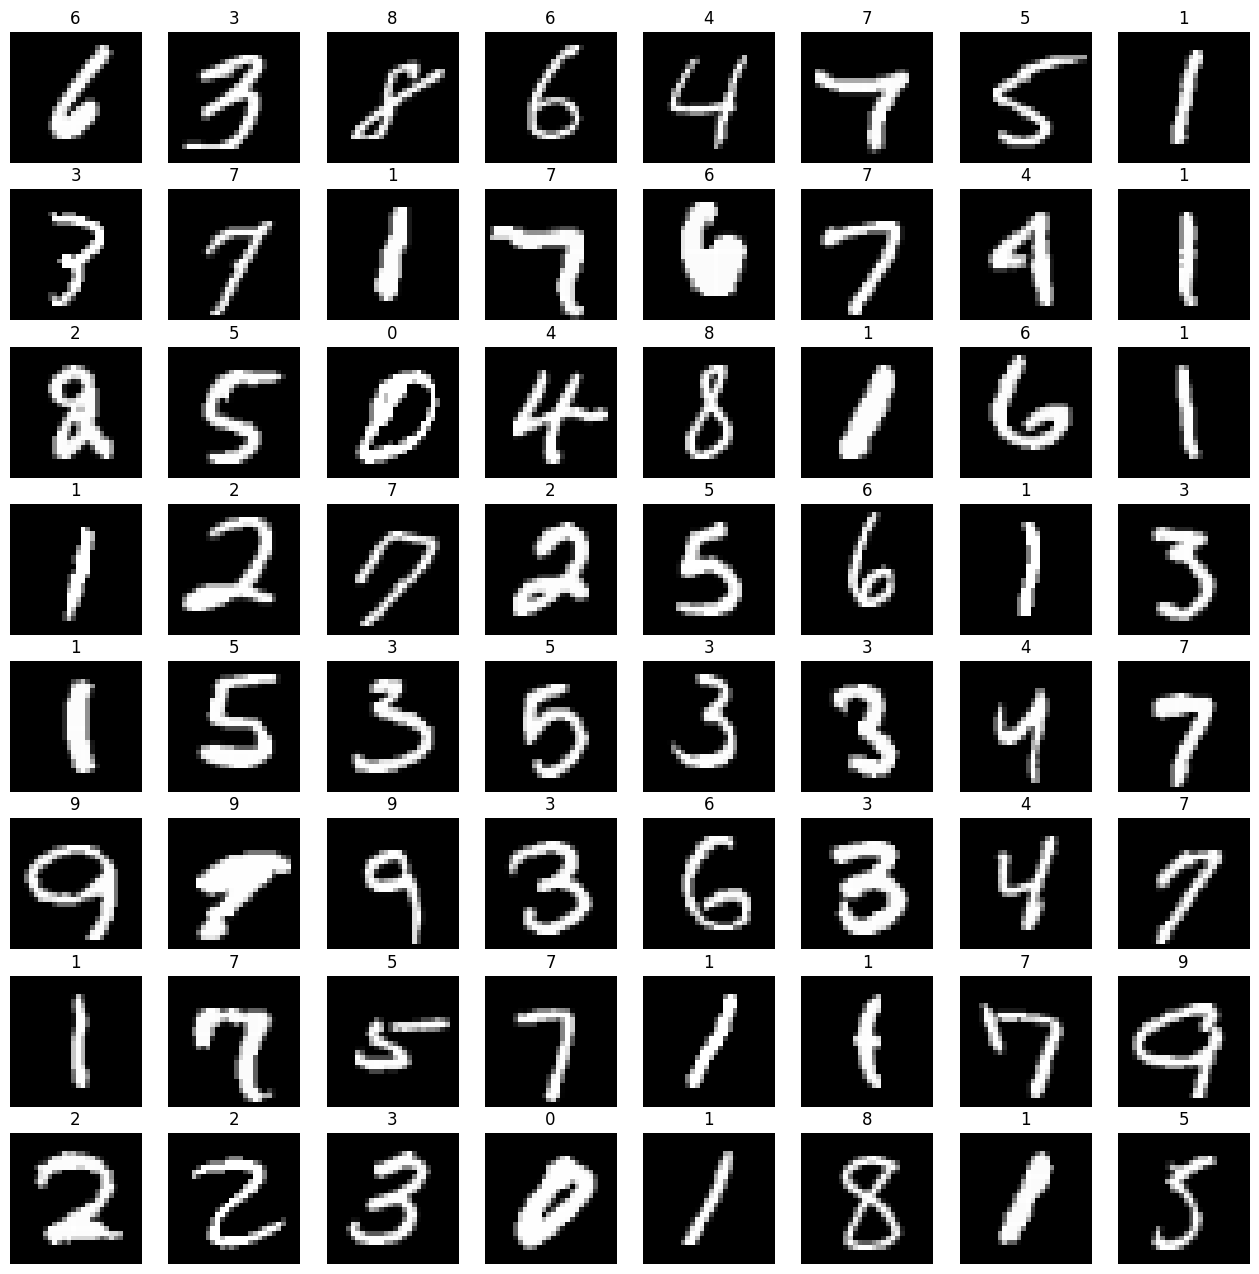

In [ ]:
loader = DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = True
)

imgs, labels = next(iter(loader))
fig, axes = plt.subplots(8,8,figsize=(16,16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1,32,kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32,64,kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(7*7*64, 10)
).to(device)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=10, bias=True)
)


In [ ]:
# 학습
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(loader)
    avg_acc = sum_accs / len(loader)
    print(f'Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    1/10 Loss: 0.188951 Accuracy: 94.44
Epoch    2/10 Loss: 0.056390 Accuracy: 98.24
Epoch    3/10 Loss: 0.040385 Accuracy: 98.78
Epoch    4/10 Loss: 0.032060 Accuracy: 98.99
Epoch    5/10 Loss: 0.025108 Accuracy: 99.23
Epoch    6/10 Loss: 0.020404 Accuracy: 99.36
Epoch    7/10 Loss: 0.017459 Accuracy: 99.46
Epoch    8/10 Loss: 0.013931 Accuracy: 99.56
Epoch    9/10 Loss: 0.010508 Accuracy: 99.66
Epoch   10/10 Loss: 0.009656 Accuracy: 99.66


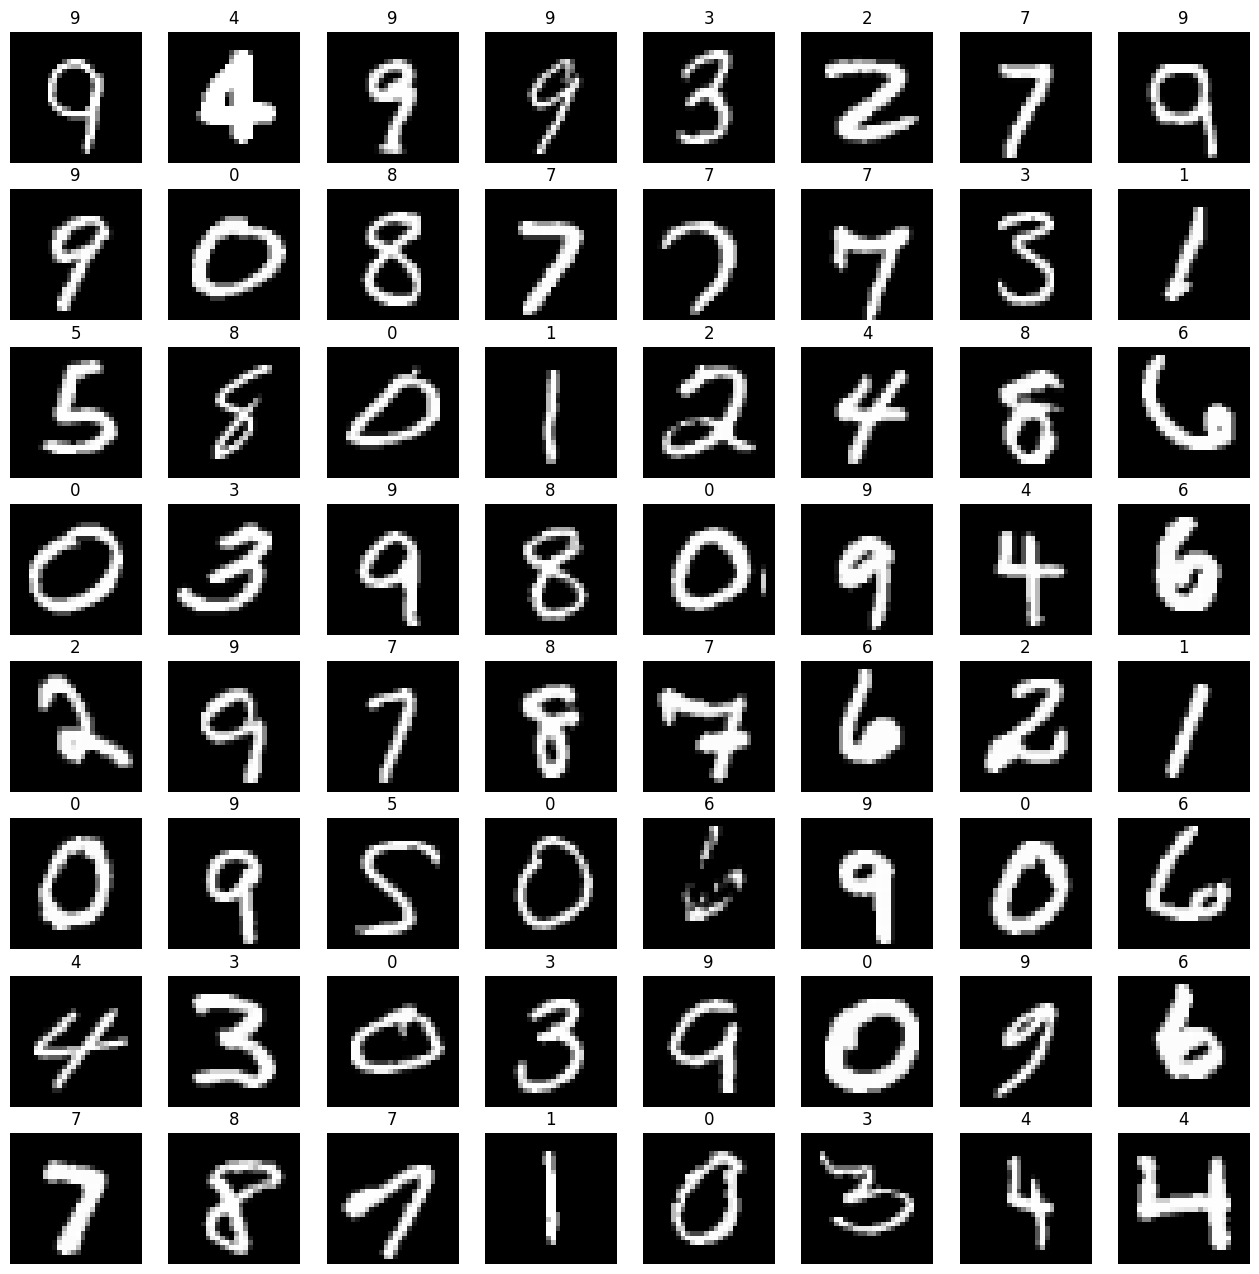

In [ ]:
test_loader = DataLoader(
    dataset = test_data,
    batch_size = 64,
    shuffle = True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(8,8,figsize=(16,16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape((28,28)), cmap='gray')
    ax.set_title(label.item())
    ax.axis('off')

In [ ]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs=0

for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

avg_acc = sum_accs / len(test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}%입니다!')

테스트 정확도는 98.98%입니다!
